# Community Water System Prediction Model

The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates 2800 Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season. This code creates a machine learning model that predicts which CWS face the highest risk of running out of water. The model is intended to run in production on a monthly basis, producing predictions for at-risk CWS within the subsequent ninety days. 

See the following resources:
* A [searchable website](https://sdwis.waterboards.ca.gov/PDWW/) of community water systems
* A [searchable map](https://gispublic.waterboards.ca.gov/portal/apps/webappviewer/index.html?id=272351aa7db14435989647a86e6d3ad8) of community water systems

In [1]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
import time
from datetime import datetime as dt_obj
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 2867)

### Create 2021 Data

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021: `DroughtWatchPrioritization_v4.csv` and 
`DroughtWatchPrioritization_v9_input_data_with_TNC.csv`.  The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`. If `DroughtExperienced` equals 1, a CWS ran out of water; otherwise, the system was safe.

This is a map that visualizes the location of each CWSID.

In [2]:
BUCKET_NAME = 'aae-water-dev-us-west-2'

In [3]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
water_bucket = s3.Bucket(BUCKET_NAME)

In [4]:
files = []
for water_bucket_object in water_bucket.objects.all():
    files.append(water_bucket_object.key)

In [5]:
dfs = []
for file in files:
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=file)
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    time.sleep(2)
    print(status, file)
    if status == 200:
        dfs.append(pd.read_csv(response.get("Body")))

200 2022BottledHauledWater_Drought Experienced.csv
200 2022BottledHauledWater_Excluded.csv
200 202304_TNC monthly-flow estimation.csv
200 CDAG.csv
200 Curtailed.csv
200 Drinking_Water_Risk_Assessment.csv
200 DroughtWatchPrioritization_v4.csv
200 DroughtWatchPrioritization_v9_input_data_with_TNC.csv
200 EAR.csv
200 Funding_DFA.csv
200 Funding_DWR.csv
200 GWSWSources.csv
200 HUC_Code_Name_Crosswalk.csv
200 Interties.csv
200 SAFER_CLEARINGHOUSE_Wholesalers.csv
200 Service_Connection_Moratoriums.csv
200 Source_Capacity_Violations.csv
200 Water_Outage_Report_SDWISViolations.csv
200 dsci_export_20180501_20230524.csv
200 monthly_net_purchaser_output.csv
200 pws_intertie_sources.csv
200 seasonal_gw_measurements_output.csv
200 seasonal_net_purchaser_output.csv


Read in the initial data sets:

In [6]:
file_index_0 = files.index('DroughtWatchPrioritization_v4.csv')
file_index_1 = files.index('DroughtWatchPrioritization_v9_input_data_with_TNC.csv')

In [7]:
df1 = dfs[file_index_0]
df2 = dfs[file_index_1]

The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [8]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Why are there multiple CWS at the same location? Is this correct? (See table below)

In [9]:
df2[['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

,ServiceConnections,Population,CDAG_rank,PWPhysicalAddressLat,PWPhysicalAddressLong
30,1742,4943,-1,38.382864,-120.787745
31,520,1060,2322,38.480957,-120.847427
32,388,907,1805,38.413058,-120.658861
33,215,510,1757,38.544707,-120.741079
34,211,1184,1445,38.191586,-120.829103
35,337,838,1636,38.458547,-120.541518
36,2743,8809,-1,38.382864,-120.787745
37,82,200,1713,38.447565,-120.537917
38,55,188,-1,38.382864,-120.787745


What does a CDAG_rank of -1 mean? Is this the same as NaN? There are 666 CWS with a CDAG_rank of -1. (Showing only ten here).

In [10]:
df1[['ServiceConnections', 'Population', 'CWSID', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']].loc[df1['CDAG_rank'] == -1][10:20] 

,ServiceConnections,Population,CWSID,CDAG_rank,PWPhysicalAddressLat,PWPhysicalAddressLong
29,2106,6170,CA0310002,-1,38.382864,-120.787745
30,1742,4943,CA0310003,-1,38.382864,-120.787745
36,2743,8809,CA0310012,-1,38.382864,-120.787745
38,55,188,CA0310019,-1,38.382864,-120.787745
73,29610,104908,CA0410002,-1,39.719981,-121.808483
76,3551,10698,CA0410005,-1,39.511060,-121.554885
77,6909,22780,CA0410006,-1,39.510752,-121.519610
78,2369,4600,CA0410007,-1,39.768527,-121.599204
79,3077,10154,CA0410008,-1,39.532157,-121.574237
81,3198,10513,CA0410011,-1,39.819135,-121.590983


Why are there 38 CWSIDs with a population of zero? It looks like these are wholesalers that only sell water; however, SDWIS assigns a population to these CWS, e.g. [CA3710042](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=3927&tinwsys_st_code=CA) serves 3.3M people.

In [11]:
df1[df1['Population'] == 0.0][['CWSID','RegulatingAgency','WaterSystemName','Population','DroughtExperienced']]

,CWSID,RegulatingAgency,WaterSystemName,Population,DroughtExperienced
415,CA1410002,DISTRICT 13 - SAN BERNARDINO,LADWP - INDEPENDENCE,0,0
416,CA1410003,DISTRICT 13 - SAN BERNARDINO,LADWP - LONE PINE,0,0
417,CA1410004,DISTRICT 13 - SAN BERNARDINO,LADWP - BIG PINE,0,0
426,CA1410510,DISTRICT 13 - SAN BERNARDINO,LADWP - MANZANAR,0,0
586,CA1510040,DISTRICT 12 - VISALIA,KERN COUNTY WATER AGENCY,0,0
594,CA1510053,DISTRICT 19 - TEHACHAPI,ANTELOPE VALLEY E KERN WTR AGY-ROSAMOND,0,0
757,CA1910032,DISTRICT 07 - HOLLYWOOD,FOOTHILL MUNICIPAL WATER DIST.,0,0
765,CA1910041,DISTRICT 07 - HOLLYWOOD,THREE VALLEYS MWD,0,0
769,CA1910045,DISTRICT 16 - CENTRAL,ANTELOPE VALLEY EAST KERN WATER AGENCY,0,0
772,CA1910048,DISTRICT 22 - ANGELES,SANTA CLARITA VALLEY W.A.-IMPORTED DIVIS,0,0


Why are there far more active groundwater sources for this CWSID, yet CA0110001 is identified as primarily a surfacewater source (see [here](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=29&tinwsys_st_code=CA))?

Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [12]:
df_2021 = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Remove the '-' character from the HUC8 values to make them consistent with other datasets.

In [13]:
df_2021['HUC8'] = df_2021['HUC8'].str.replace("-", "").astype(int)

In [14]:
df_2021 = df_2021.rename(columns={'EAR2020DroughtRiskScore_y':'EARDroughtRiskScore'}).reset_index(drop=True)

In [15]:
print("In 2021, ",df_2021[df_2021['DroughtExperienced_y'] == 1]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  1161365 people in California experienced some form of drought.


In [16]:
df_2021.shape

(2866, 78)

In [17]:
df_2021.columns

Index(['CWSID', 'RegulatingAgency', 'WaterSystemName',
       'Score_DroughtWatchStatus', 'WaterOutageDroughtViolation',
       'BottledHauledWaterOrZeroSource', 'CurtailmentExemptionPetition',
       'Score_1704', 'FundedProject', 'DroughtExperienced_x',
       'ServiceConnections', 'Population', 'Score_SourceNumber_x', 'Score_SCV',
       'Score_SCM_x', 'Score_CriticallyOverdraftedGroundwaterBasin_x',
       'CDAG_rank', 'Curtailment_x', 'Score_1702_x', 'Score_1705_x',
       'Score_1706_x', 'Score_1812_x', 'Score_1813_x', 'Score_1814_x',
       'Score_1815_x', 'EAR2020DroughtRiskScore_x',
       'SAFER_AccessibilityScore_x', 'PWPhysicalAddressLat',
       'PWPhysicalAddressLong_x', 'CentralValleyCounties',
       'NonCentralValleyCounties', 'ActiveGWSource_x', 'ActiveSWSource_x',
       'CurtailedWatershed_x', 'HUC4_x', 'HUC8_CentralValley', 'HUC8_Coast',
       'HUC8_Other', 'Basin_Number_part1_x', 'FracturedRock_x', 'Basin12_x',
       'Basin34_x', 'Basin5_x', 'Basin6_x', 'Basin78

### Add Intertie Data

The intertie, or purchaser/seller, data (`pws_intertie_sources.csv`) contains data that described which public water systems purchased or sold water. These data are available for 752 public water systems. There are three types of public water systems: 
1. C - Community: Serves at least 15 service connections used by year-round residents or regularly serves 25 year-round residents.
2. NTNC - Non-Transient Non-Community: Serves at least the same 25 non-residential individuals during 6 months of the year.
3. NC - Transient Non-Community: Regularly serves at least 25 non-residential individuals (transient) during 60 or more days per year.

For the purposes of this study, we are only interested in community water systems. To whittle out the NTNC and NC water systems from the intertie data, we used [a list](https://sdwis.waterboards.ca.gov/PDWW/JSP/SearchDispatch?number=&name=&county=&WaterSystemType=All&WaterSystemStatus=A&SourceWaterType=All&action=Search+For+Water+Systems) of all the public water systems in the state mtaintained by The California Safe Drinking Water Information System. This list is also available on the [California Open Data Portal](https://data.ca.gov/dataset/drinking-water-public-water-system-information). After selecting only the community water systems and removing any NTNC or NC water systems, we are left with 671 community water systems or 23% of the total community water systems.

In order to use these data, we must impute the missing values. Let's see if it is reasonable to make the following assumptions:

* Assumption 1: Community water systems missing from this dataset do not have an intertie. **False**  
There are 103 community water systems with an Intertie value equal to one, but not included in the purchaser/seller dataset. Therefore, we cannot assume all community water systems in the purchaser/seller dataset have no interties. 

* Assumption 2: Community water systems missing from this dataset do not purchase or sell water. **False**  
Of these 103 community water systems, some have purchased water. We can take a look at one example: Community Water System [CA4810800](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=4860&tinwsys_st_code=CA), California State Prison in Solano, has an intertie value of 1. It also purchased water from Community Water System CA4810008, the City of Vacaville. Nevertheless, we made Assumption 2 for the sake of experiment. Using both the Univariate Fisher / ANOVA F Score and Gini Impurity Importance, we found that none of the features are predictive.

For all these reasons, we do not use the intertie data in our analysis.

In [27]:
# Read in the intertie data
file_index = files.index('pws_intertie_sources.csv')
print("Reading in",files[file_index],".")
df_intertie = dfs[file_index]

Reading in pws_intertie_sources.csv .


In [28]:
df_intertie.columns

Index(['pwsid', 'num_sources_purchased_from', 'num_sources_sold_to',
       'net_purchases', 'net_purchaser_flag'],
      dtype='object')

In [29]:
# Read in the list of all the public water systems
df_pws_calopendata = pd.read_csv('https://data.ca.gov/dataset/d6d3beac-6735-4127-9324-4e70f61698d9/resource/9dca2f92-4630-4bee-a9f9-69d2085b57e3/download/drinking-water-watch-public-water-system-facilities.txt', 
                                on_bad_lines='skip', delimiter='\t', header=None)

In [30]:
# Select rows that describe the public water system id and type (C, NTNC, or NC).
df_pws = df_pws_calopendata[[3,7]].rename(columns={7: "Type", 3: "pwsid"})

In [31]:
# Merge the list of all public water systems with the intertie data
df_intertie_and_pws = df_intertie.merge(df_pws, on='pwsid', how='left')

In [32]:
# Select only community water systems
df_intertie_and_cws = df_intertie_and_pws[df_intertie_and_pws['Type'] == 'C'].reset_index(drop=True).rename(columns={'pwsid': 'CWSID'})

In [37]:
# Print some statistics
print("The intertie data covers", df_intertie_and_cws['CWSID'].count(),"community water systems.")
print("The intertie data covers", df_intertie_and_cws['CWSID'].count()/df_2021['CWSID'].count()*100.,"% of the community water systems.")

The intertie data covers 671 community water systems.
The intertie data covers 23.41242149337055 % of the community water systems.


In [38]:
# Merge the community water system and intertie data with the initial data
df_2021_plus_intertie = df_2021.merge(df_intertie_and_cws, on='CWSID', how='left')

In [39]:
# Select only data where there is an intertie (i.e. the value of Intertie_x is equal to 1)
df_test_assumptions = df_2021_plus_intertie[(df_2021_plus_intertie['Intertie_x'] == 1)].reset_index(drop=True)

In [43]:
# Select the community water systems for which there is no value for the number of monthly purchases
df_test_assumptions = df_test_assumptions[df_test_assumptions['num_sources_purchased_from'].isnull()]

In [45]:
# Count the number of community water systems for which there is an intertie but no value for the number of monthly purchases
df_test_assumptions[['CWSID','Intertie_x','Score_SourceNumber_x','num_sources_purchased_from','num_sources_sold_to']].count()

CWSID                         103
Intertie_x                    103
Score_SourceNumber_x          103
num_sources_purchased_from      0
num_sources_sold_to             0
dtype: int64

In [47]:
# Look at one CWS in particular
df_test_assumptions[df_test_assumptions['CWSID'] == 'CA4810800'][['CWSID', 'RegulatingAgency', 'WaterSystemName', 
                                                                  'Intertie_x','Score_SourceNumber_x','num_sources_purchased_from','num_sources_sold_to']]

,CWSID,RegulatingAgency,WaterSystemName,Intertie_x,Score_SourceNumber_x,num_sources_purchased_from,num_sources_sold_to
565,CA4810800,DISTRICT 04 - SAN FRANCISCO,CALIFORNIA STATE PRISON - SOLANO,1,0.0,NaN,NaN


In [48]:
# Make assumption 2

df_2021_plus_intertie['num_sources_purchased_from'] = df_2021_plus_intertie['num_sources_purchased_from'].fillna(0)
df_2021_plus_intertie['num_sources_sold_to'] = df_2021_plus_intertie['num_sources_sold_to'].fillna(0)

One particular attribute of the The California Safe Drinking Water Information System list assesses whether a water system is primarily a groundwater or surface water site. According to the [EPA's Detailed Facility Report Data Dictionary](https://echo.epa.gov/help/reports/dfr-data-dictionary), there are six different types of water sources:

* Surface Water - System has a surface source (e.g., river, reservoir, intake).  
* Ground Water - System has a groundwater source that is not under the direct influence of surface water (e.g., protected wells) and no surface water or groundwater under the influence of surface water sources.
* Ground Water Under Direct Influence of (UDI) Surface Water - System has a source that provides water under the direct influence of surface water (e.g., unprotected well or springs) and no surface water sources. 
* Purchased Surface Water - System purchases water that originates from a surface source (e.g., river, reservoir, intake.
* Purchased Groundwater - System purchases water that originates from groundwater source that is not under the direct influence of surface water (e.g., protected wells) and no surface water or groundwater under the influence of surface water sources.
* Purchased Groundwater UDI Surface Water - System purchases water that originates from a source that provides water under the direct influence of surface water(e.g., unprotected well or springs)and no surface water sources.

We incorporate this information into our initial data set by creating two new keys:

1. `Primary Source`, where `Groundwater` and `Groundwater Purchased` represents groundwater sources and equals 0, and the rest (`Surface Water`, `Groundwater UDI Surface Water`, `Surface Water Purchased`, `Groundwater UDI Surface Water Purchased`) represent surface water sources and equal 1.
2. `Purchased`, where `Groundwater Purchased`, `Surface Water Purchased`, and `Groundwater UDI Surface Water Purchased` represent purchased sources and equal 1, and the rest (`Groundwater`, `Surface Water`, `Groundwater UDI Surface Water`) represent non-purchased sources and equal 0.

When dividing the data this way, we are left with 2020 groundwater sources (`Primary Source == 0`) and 829 surface water sources. We are also left with 427 CWS that purchased water, and 2442 that did not purchase water.

The model does not perform any better when incorporating this type of purchasing data (as opposed to the intertie data), nor does performance improve by only including groundwater sources. Therefore, we do not need to use these keywords.

In [49]:
df_pws_calopendata[16].unique()

array(['Groundwater', 'Surface Water', 'Groundwater UDI Surface Water',
       'Groundwater Purchased', 'Surface Water Purchased', nan,
       'Groundwater UDI Surface Water Purchased'], dtype=object)

In [50]:
# Select rows that describe the source of water and create two new keys
df_pws = df_pws_calopendata[[16, 3]].rename(columns={16: "Primary Source", 3:'CWSID'})
df_pws['Purchased'] = df_pws['Primary Source'] 

In [51]:
# Create Primary Source
primary_source_dictionary = {'Groundwater': 0, 'Surface Water':1, 'Groundwater UDI Surface Water':1,
       'Groundwater Purchased':0, 'Surface Water Purchased':1,
       'Groundwater UDI Surface Water Purchased':1, np.nan: np.nan}
df_pws['Primary Source'] = df_pws['Primary Source'].apply(lambda x: primary_source_dictionary[x])

In [52]:
# Create Purhased
purchased_dictionary = {'Groundwater': 0, 'Surface Water':0, 'Groundwater UDI Surface Water':0,
       'Groundwater Purchased':1, 'Surface Water Purchased':1,
       'Groundwater UDI Surface Water Purchased':1, np.nan: np.nan}
df_pws['Purchased'] = df_pws['Purchased'].apply(lambda x: purchased_dictionary[x])

In [53]:
# Merge the list of all public water systems with the intertie data
df_2021_plus_pws = df_2021.merge(df_pws, on='CWSID', how='left').drop_duplicates().dropna()

In [54]:
df_2021_plus_pws.shape

(2849, 80)

In [55]:
df_2021_plus_pws['Purchased'].value_counts()

0.0    2422
1.0     427
Name: Purchased, dtype: int64

In [56]:
df_2021_plus_pws['Primary Source'].value_counts()

0.0    2020
1.0     829
Name: Primary Source, dtype: int64

### Add [Periodic Groundwater Level Measurements](https://data.cnra.ca.gov/dataset/periodic-groundwater-level-measurements) data

The Periodic Groundwater Level Measurement data, in the file `seasonal_gw_measurements_output.csv`, contains groundwater level measurements, taken periodically, for 2051 water systems. The groundwater data includes some public, but not community, water systems, e.g. CA0202501 (see a complete [list of all the community water systems in California](https://sdwis.waterboards.ca.gov/PDWW/JSP/SearchDispatch?number=&name=&county=&WaterSystemType=All&WaterSystemStatus=A&SourceWaterType=All&action=Search+For+Water+Systems) from the The Safe Drinking Water Information System). If we restict the data to include only community water systems that have data for both the wet and dry seasons of 2021, we have data for 1614 out of the 2866 groundwater sites, or 56% coverage. The outcome label experiences a similar decrease in coverage, from 156 to 83 positive examples.

This spase coverage means we need to impute almost half of the data, which will introduce a lot of noise into the dataset. In general, it is not adviseable to impute more than 10% of missing data. We can do a test by withholding some data, imputing the values for the witheld data, and then comparing the imputed values to the real values. We could possibly create categorical variables out of the numerical ones, applying a threshold at various points, and applying a neutral value to the remaining data.

Some notes about the groundwater metadata:
* Some CWSIDs do not have measurements taken during a dry or wet season, but have measurements taken during the opposite season. 
* If the value for the variable `gwe_std` is NaN, the value in the corresponding variable `gws_avg` represents one data point. 
* If the value for `CWSID` is NaN, there was some missing data in the mapping between basin and CWSID.
* Definitions for the feature named `season`: `2021_wet` corresponds to the time frame between 2020-10-01 and 2021-04-01. Therefore, `2022_wet` corresponds to the time frame between 2021-10-01 and 2022-04-01 and `2023_wet` corresponds to the time frame between 2022-10-01 and 2023-04-01.

In [58]:
# Read in the groundwater data
file_index = files.index('seasonal_gw_measurements_output.csv')
print("Reading in",files[file_index],".")
df_groundwater = dfs[file_index]

Reading in seasonal_gw_measurements_output.csv .


In [59]:
# Drop the columns basin_code and gwe_std, and rename PWSID to CWSID
df_groundwater = df_groundwater.drop(columns=['basin_code', 'gwe_std'])
df_groundwater = df_groundwater.rename(columns={"PWSID": "CWSID"})

In [60]:
# Drop all the values for which the CWSID is NaN
df_groundwater = df_groundwater[df_groundwater['CWSID'].notna()]

In [61]:
print("Number of CWSIDs that are not NaN:", df_groundwater['CWSID'].nunique())
print("Total number of possible CWSIDs:", df_2021['CWSID'].nunique())
print("Percentage of represented CWSIDs:", df_groundwater['CWSID'].nunique()/df_2021['CWSID'].nunique())

Number of CWSIDs that are not NaN: 2051
Total number of possible CWSIDs: 2866
Percentage of represented CWSIDs: 0.7156315422191207


In [62]:
# Drop all the values for which the average groundwater is NaN
df_groundwater = df_groundwater[df_groundwater['gwe_avg'].notna()]

In [63]:
# Choose all the rows that have values for the 2022 wet and dry season
df_groundwater = df_groundwater.loc[df_groundwater['season'].isin(['2021_wet', '2021_dry'])].reset_index(drop=True)

In [64]:
# Choose all CWSIDs that have values for both 2021_wet and 2021_dry
df_groundwater = df_groundwater[df_groundwater['CWSID'].duplicated()].reset_index(drop=True)

In [65]:
df_2021_plus_groundwater = df_2021_plus_intertie.merge(df_groundwater, on='CWSID', how='left')

In [66]:
df_2021_plus_groundwater = df_2021_plus_groundwater[df_2021_plus_groundwater['gwe_avg'].notna()].reset_index(drop=True)

In [67]:
print("Number of PWSIDs that are not NaN:", df_groundwater['CWSID'].nunique())
print("Number of non-NaN PWSIDs that are CWSIDs:", df_2021_plus_groundwater['CWSID'].nunique())
print("Total number of possible CWSIDs:", df_2021['CWSID'].nunique())
print("Percentage of represented CWSIDs:", df_2021_plus_groundwater['CWSID'].nunique()/df_2021['CWSID'].nunique())

Number of PWSIDs that are not NaN: 1847
Number of non-NaN PWSIDs that are CWSIDs: 1614
Total number of possible CWSIDs: 2866
Percentage of represented CWSIDs: 0.5631542219120725


### Add [California Natural Flows Data](https://rivers.codefornature.org)

The California Natural Flows Database (NFD) contains predicted natural stream flows for every stream in California at a monthly cadence from 1950 to 2022. The Nature Conservancy and the USGS used a three different random forest algorithms to model the flow rate in three different regions:
* Interior Mountains (including the Sierra Nevada and Klamath mountains)
* North Coastal Mountains (including the mountains in the north western portion of the state)
* Xeric (including the Central Valley, Central and South Coast, and desert portions of the state)

The process is described in [Zimmerman et al. 2017](https://doi.org/10.1111/fwb.13058). They acknowledge inflated values during the dry season, saying: "While the frequency of monthly flow alteration tended to be low, the degree of alteration was substantial. ... Inflation of monthly flows was most pronounced in the dry summer months, when flows in California streams are typically at their lowest level."

It may be useful to use actual measurements, rather than predicted values -- e.g. data from the [California Nevada River Forecast Center](https://www.cnrfc.noaa.gov/).


**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain flow data per HUC8 code per unit time.** The data are provided in a field called `value`.  

Complete Step 1:

In [68]:
url_huc8 = 'https://gis.data.cnra.ca.gov/datasets/02ff4971b8084ca593309036fb72289c_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'

In [69]:
df_huc8 = pd.read_csv(url_huc8)

Complete Step 2:

In [75]:
# Read in the TNC flow data
file_index = files.index('202304_TNC monthly-flow estimation.csv')
print("Reading in",files[file_index],".")
df0 = dfs[file_index]

Reading in 202304_TNC monthly-flow estimation.csv .


In [76]:
df0['Date'] = df0[['year', 'month']].astype(str).agg('-'.join, axis=1) 

In [77]:
df0 = df0.drop(columns=['comid', 'statistic', 'variable', 'month', 'year', 'pct_rank',
       'GNIS_NAME', 'FTYPE', 'FCODE', 'stream_ord', 'name', 'method'])

In [78]:
# Convert the keyword MapDate into a datetime object
df0['Date'] = pd.to_datetime(df0['Date'], format = '%Y-%m').reset_index(drop=True)

In [79]:
# Define the dry season 2021
start_dry_season = dt_obj.fromisoformat('2021-05-01')
end_dry_season = dt_obj.fromisoformat('2021-09-30')

# Define the wet season 2021
start_wet_season = dt_obj.fromisoformat('2021-10-01')
end_wet_season = dt_obj.fromisoformat('2022-04-01')

In [80]:
all_huc_ids = []
all_average_flows_dry_season = []
all_max_flows_dry_season = []
all_standard_deviation_flows_dry_season = []
all_delta_flows = []
for i in range(len(df_huc8['HUC8'])):  
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    print('Calculating features for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    df_one_huc = df0[df0['huc8'] == one_huc8_code]

    # Identify the dry season
    mask_dry = (df_one_huc['Date'] > start_dry_season) & (df_one_huc['Date'] <= end_dry_season)
    df_dry = df_one_huc[mask_dry]
    
    # Calculate the maximum, average, and standard deviation of the flow during the dry season
    max_flow_dry_season = np.nanmax(df_dry['value'])
    average_flow_dry_season = np.nanmean(df_dry['value'])
    standard_deviation_dry_season_flow = np.nanstd(df_dry['value'])
    
    # Identify the wet season
    mask_wet = (df_one_huc['Date'] > start_wet_season) & (df_one_huc['Date'] <= end_wet_season)
    df_wet = df_one_huc[mask_wet]
    
    # Calculate the average flow during the wet season
    average_flow_wet_season = np.nanmean(df_wet['value'])
    
    # Calculate the change in average flow between dry and wet seasons
    delta_flow = average_flow_dry_season - average_flow_wet_season
    
    # Save the data to a list
    all_huc_ids.append(one_huc8_code)
    all_max_flows_dry_season.append(max_flow_dry_season)
    all_average_flows_dry_season.append(average_flow_dry_season)
    all_standard_deviation_flows_dry_season.append(standard_deviation_dry_season_flow)
    all_delta_flows.append(delta_flow)

Calculating features for HUC8 region 18100204 Salton Sea
Calculating features for HUC8 region 18070303 San Luis Rey-Escondido
Calculating features for HUC8 region 18070304 San Diego
Calculating features for HUC8 region 18020162 Upper Putah
Calculating features for HUC8 region 18050001 Suisun Bay
Calculating features for HUC8 region 15030102 Piute Wash
Calculating features for HUC8 region 18100100 Southern Mojave
Calculating features for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Calculating features for HUC8 region 18060003 Carrizo Plain
Calculating features for HUC8 region 18060007 Cuyama
Calculating features for HUC8 region 18070102 Santa Clara
Calculating features for HUC8 region 18090206 Antelope-Fremont Valleys
Calculating features for HUC8 region 18020002 Upper Pit
Calculating features for HUC8 region 18080002 Madeline Plains
Calculating features for HUC8 region 17100309 Applegate
Calculating features for HUC8 region 17100311 Illinois
Calculating features for HUC8

In [81]:
df_flow_data = pd.DataFrame({'HUC8': all_huc_ids, 
                   'Flow Dry Season Max': all_max_flows_dry_season,        
                   'Flow Dry Season Average': all_average_flows_dry_season,
                   'Flow Dry Season Standard Deviation': all_standard_deviation_flows_dry_season,
                   'Flow Dry Wet Delta': all_delta_flows})

In [82]:
df_2021_plus_flow = df_2021.merge(df_flow_data, on='HUC8', how='left')
#df_2021_plus_flow = df_2021_plus_groundwater.merge(df_flow_data, on='HUC8', how='left')

In [83]:
df_2021_plus_flow.shape

(2866, 82)

### Add [US Drought Monitor Data](https://droughtmonitor.unl.edu/)

The US Drought Monitor Database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). These data are available on a weekly cadence from 2000 until the present day.

**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain DSCI data per HUC8 code per unit time.** 
* The [US Drought Monitor Index](https://droughtmonitor.unl.edu/) provides several drought-related datasets. These data are available through a REST API. 
* Construct the URL for the REST API. The query terms are: 
  * `[area]` = `HUCStatistics`
  * `[statistics type]` = `GetDroughtSeverityStatisticsByAreaPercent` (Note: One could use `GetDSCI`, but this will not return HUC8 codes as a key)
  * `[aoi]` = Any given HUC8 code, e.g. 15040004
  * `[start date]` = 01/01/2021
  * `[end date]` = 01/01/2022
  * `[statistics type]` = 2. (Note: This is a different keyword from the first statistics type. A statistics type of 2 refers to categorical statistics).
* Here is an example URL: url_dsci = `https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi=15040004&startdate=1/2/2021&enddate=12/27/2021&statisticsType=2`

**Step 3: Calculate the Drought Severity and Coverage Index (DSCI).** Compute a weighted sum of the categorical percent area as described [here](https://droughtmonitor.unl.edu/About/AbouttheData/DSCI.aspx): DSCI = 1(D0) + 2(D1) + 3(D2) + 4(D3) + 5(D4)

Step 1, add additional seasons:

In [84]:
# Define the dry seasons
dry_seasons_start = [dt_obj.fromisoformat('2021-05-01'), dt_obj.fromisoformat('2020-05-01'), dt_obj.fromisoformat('2019-05-01')]
dry_seasons_end = [dt_obj.fromisoformat('2021-09-30'), dt_obj.fromisoformat('2020-09-30'), dt_obj.fromisoformat('2019-09-30')]

# Define the wet seasons
wet_seasons_start = [dt_obj.fromisoformat('2021-10-01'), dt_obj.fromisoformat('2020-10-01'), dt_obj.fromisoformat('2019-10-01')]
wet_seasons_end = [dt_obj.fromisoformat('2022-04-01'), dt_obj.fromisoformat('2021-04-01'), dt_obj.fromisoformat('2020-04-01')]

Complete Steps 2 and 3:

In [85]:
all_huc_ids = []
all_average_dscis_dry_season = []
all_max_dscis_dry_season = []
all_standard_deviation_dscis_dry_season = []
all_delta_dscis = []
years_average_dscis_dry_season = []
years_max_dscis_dry_season = []
years_standard_deviation_dscis_dry_season = []
years_delta_dscis = []
for i in range(len(df_huc8['HUC8'])):
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    print('Fetching data for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    url_dsci = 'https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi='+str(one_huc8_code)+'&startdate=1/1/2019&enddate=12/31/2021&statisticsType=2'
    df_one_huc = pd.read_json(url_dsci)
    
    # Convert the keyword MapDate into a datetime object
    df_one_huc['MapDate'] = pd.to_datetime(df_one_huc['MapDate'], format = '%Y%m%d').reset_index(drop=True)
    
    # Save the data to a list
    all_huc_ids.append(one_huc8_code)

    for j in range(len(dry_seasons_start)):
        # Identify one dry season
        mask_dry = (df_one_huc['MapDate'] > dry_seasons_start[j]) & (df_one_huc['MapDate'] <= dry_seasons_end[j])
        df_dry = df_one_huc[mask_dry]

        # Calculate the maximum, average, and standard deviation of the DSCI during the dry season
        max_dsci_dry_season = np.nanmax(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
        average_dsci_dry_season = np.nanmean(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
        standard_deviation_dry_season_dsci = np.nanstd(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)

        # Identify one wet season
        mask_wet = (df_one_huc['MapDate'] > wet_seasons_start[j]) & (df_one_huc['MapDate'] <= wet_seasons_end[j])
        df_wet = df_one_huc[mask_wet]

        # Calculate the average DSCI during the wet season
        average_dsci_wet_season = np.nanmean(1*df_wet.D0 + 2*df_wet.D1 + 3*df_wet.D2 + 4*df_wet.D3 + 5*df_wet.D4)

        # Calculate the change in average DSCI between dry and wet seasons
        delta_dsci = average_dsci_dry_season - average_dsci_wet_season
    
        # Concatenate each feature by years
        years_max_dscis_dry_season.append(max_dsci_dry_season)
        years_average_dscis_dry_season.append(average_dsci_dry_season)
        years_standard_deviation_dscis_dry_season.append(standard_deviation_dry_season_dsci)
        years_delta_dscis.append(delta_dsci)
    
    # Save the data to a list
    all_max_dscis_dry_season.append(years_max_dscis_dry_season)
    all_average_dscis_dry_season.append(years_average_dscis_dry_season)
    all_standard_deviation_dscis_dry_season.append(years_standard_deviation_dscis_dry_season)
    all_delta_dscis.append(years_delta_dscis)
    
    years_average_dscis_dry_season = []
    years_max_dscis_dry_season = []
    years_standard_deviation_dscis_dry_season = []
    years_delta_dscis = []

Fetching data for HUC8 region 18100204 Salton Sea
Fetching data for HUC8 region 18070303 San Luis Rey-Escondido
Fetching data for HUC8 region 18070304 San Diego
Fetching data for HUC8 region 18020162 Upper Putah
Fetching data for HUC8 region 18050001 Suisun Bay
Fetching data for HUC8 region 15030102 Piute Wash
Fetching data for HUC8 region 18100100 Southern Mojave
Fetching data for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Fetching data for HUC8 region 18060003 Carrizo Plain
Fetching data for HUC8 region 18060007 Cuyama
Fetching data for HUC8 region 18070102 Santa Clara
Fetching data for HUC8 region 18090206 Antelope-Fremont Valleys
Fetching data for HUC8 region 18020002 Upper Pit
Fetching data for HUC8 region 18080002 Madeline Plains
Fetching data for HUC8 region 17100309 Applegate
Fetching data for HUC8 region 17100311 Illinois
Fetching data for HUC8 region 18030009 Upper Dry
Fetching data for HUC8 region 18040001 Middle San Joaquin-Lower Chowchilla
Fetching data for

In [89]:
df_drought_data = pd.DataFrame({
                   'HUC8': all_huc_ids, 
                   'DSCI 2021 Dry Season Max': [item[0] for item in all_max_dscis_dry_season],        
                   'DSCI 2021 Dry Season Average': [item[0] for item in all_average_dscis_dry_season],
                   'DSCI 2021 Dry Season Standard Deviation': [item[0] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2021 Dry Wet Delta': [item[0] for item in all_delta_dscis],
                   'DSCI 2020 Dry Season Max': [item[1] for item in all_max_dscis_dry_season],        
                   'DSCI 2020 Dry Season Average': [item[1] for item in all_average_dscis_dry_season],
                   'DSCI 2020 Dry Season Standard Deviation': [item[1] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2020 Dry Wet Delta': [item[1] for item in all_delta_dscis],  
                   'DSCI 2019 Dry Season Max': [item[2] for item in all_max_dscis_dry_season],        
                   'DSCI 2019 Dry Season Average': [item[2] for item in all_average_dscis_dry_season],
                   'DSCI 2019 Dry Season Standard Deviation': [item[2] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2019 Dry Wet Delta': [item[2] for item in all_delta_dscis],
})

In [308]:
df = df_2021_plus_flow.merge(df_drought_data, on='HUC8', how='left')

In [309]:
df['CWSID'].nunique()

2866

In [310]:
df.shape

(2866, 94)

### Select and Redefine Keywords

Rename columns so they make more sense.

In [311]:
df.columns = df.columns.str.removesuffix("_x")
df.columns = df.columns.str.removesuffix("_y")

In [312]:
# Drop duplicate columns
df = df.loc[:,~df.columns.duplicated()].copy()

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [313]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df['CentralValleyCounties'] = df['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [314]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df['FracturedRock'] = df['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [315]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df['CurtailedWatershed'] = df['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [316]:
# Create HUC_Categories

df['HUC8_CentralValley'] = df['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Coast'] = df['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df = df.replace(to_replace='HUC8_Coast', value=1)
df = df.replace(to_replace='HUC8_CentralValley', value=2)
df = df.replace(to_replace='HUC8_Other', value=3)

df['HUC_Categories'] = np.nan

df['HUC_Categories'] = df[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df = df.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

In [317]:
df['Water Year'] = 2021

Select the keywords to use in the model:

In [320]:
keywords_to_use_in_the_model = [
 'CWSID',
 'Water Year',
 'DroughtExperienced',
 'SAFER_AccessibilityScore',
 'Curtailment',
 'CDAG_rank',
 'PWPhysicalAddressLong',
 'Population',
 'ServiceConnections',
 'PWPhysicalAddressLat',
 'ActiveSWSource',
 'DSCI 2021 Dry Season Standard Deviation',
 'DSCI 2019 Dry Wet Delta',
 'ActiveGWSource',
 'EAR2020DroughtRiskScore',
 'DSCI 2020 Dry Season Standard Deviation',
 'DSCI 2020 Dry Wet Delta',
 'DSCI 2021 Dry Wet Delta',
 'DSCI2WYAvg',
 'Score_SCV',
 'DSCI 2020 Dry Season Max',
 'Score_SourceNumber',
 'DSCI 2021 Dry Season Average',
 'Score_CriticallyOverdraftedGroundwaterBasin',
 'Flow Dry Season Standard Deviation',
 'Score_1813',
 'Flow Dry Wet Delta',
 'Score_SCM',
 'TNCFlow2WYAvg',
 'DSCI 2021 Dry Season Max',
 'Score_1814',
 'DSCI 2020 Dry Season Average',
 'Flow Dry Season Average',
 'Flow Dry Season Max',
 'Score_1812',
 'HUC4',
 'Score_1702',
 'FracturedRock',
 'Score_1815',
 'Score_1705',
 'Score_1706',
 'Intertie',
 'HUC_Categories',
 'CentralValleyCounties',
 'CurtailedWatershed',
 'DSCI 2019 Dry Season Average',
 'DSCI 2019 Dry Season Max',
 'DSCI 2019 Dry Season Standard Deviation',
#'gwe_avg', 'num_purchases_monthly', 'num_sales_monthly',
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'Score_1704',
 'FundedProject'
]

In [321]:
df_2021 = df[keywords_to_use_in_the_model]

### Create 2022 Data

The original data covered the year 2021. Add data that covers the year 2022.
Follow the steps in the [Analytical File Specifications](https://docs.google.com/document/d/104HVf3_-9r174I6ZWnu0zzyngckeEz19HmvarQ5yJpM/edit).

#### A. Create a new df containing all CWSIDs

In [102]:
df_2022 = df_2021[['CWSID', 'Population']].rename(columns={'Population': 'Water Year'})

In [103]:
df_2022['Water Year'] = 2022

In [104]:
df_2022.shape

(2866, 2)

#### B. WaterOutageDroughtViolation

These data are in the file `Water_Outage_Report_SDWISViolations.csv`.

In [105]:
file_index = files.index('Water_Outage_Report_SDWISViolations.csv')
print("Reading in",files[file_index],".")
df_outage = dfs[file_index]

Reading in Water_Outage_Report_SDWISViolations.csv .


In [106]:
# Retain only three fields and rename water system id to CWSID
df_outage = df_outage[['water system id', 'Begin Date', 'End Date']].rename(columns={'water system id': 'CWSID'})

In [107]:
df_2022 = df_2022.merge(df_outage, how='left').drop_duplicates().reset_index(drop=True)

In [108]:
df_2022['WaterOutageDroughtViolation'] = np.NaN

In [109]:
# Convert the keywords Begin Date and End Date into a datetime object
df_2022['Begin Date'] = pd.to_datetime(df_2022['Begin Date'], format = '%Y-%m-%d')
df_2022['End Date'] = pd.to_datetime(df_2022['End Date'], format = '%Y-%m-%d')

In [110]:
# Identify the 2022 water season
# Define the dry season 2021
start_2022_water_season = dt_obj.fromisoformat('2021-10-01')
end_2022_water_season = dt_obj.fromisoformat('2022-09-30')

Step 1: Identify all cases where a `Begin Date` and `End Dat`e fall within any point of the 2022 water season (10/2021 - 9/2022). This identifies three cases.

In [111]:
mask_2022_water_season_1 = (df_2022['Begin Date'] > start_2022_water_season) & (df_2022['End Date'] <= end_2022_water_season)
df_water_season_1 = df_2022[mask_2022_water_season_1]

In [112]:
df_water_season_1

,CWSID,Water Year,Begin Date,End Date,WaterOutageDroughtViolation
177,CA0910006,2022,2022-07-11,2022-07-24,NaN
1431,CA3301512,2022,2022-03-01,2022-04-30,NaN
1582,CA3500823,2022,2022-05-31,2022-08-04,NaN


Step 2: Identify all cases with a `Begin Date` at any time with no end date. This identifies zero cases.

In [113]:
mask_2022_water_season_2 = (df_2022['Begin Date'] != pd.NaT) & (df_2022['End Date'] == pd.NaT)
df_water_season_2 = df_2022[mask_2022_water_season_2]

Set the value of `WaterOutageDroughtViolation` equal to 1 for the three cases identified in Step 1.

In [114]:
df_2022.loc[mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 1

And set the other values to zero.

In [115]:
df_2022.loc[~mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 0

In [116]:
df_2022 = df_2022.drop(columns=['Begin Date', 'End Date'])

In [117]:
df_2022['WaterOutageDroughtViolation'] = df_2022['WaterOutageDroughtViolation'].astype('int')

In [118]:
df_2022.shape

(2866, 3)

#### C. BottledHauledWaterOrZeroSourcedata

In [119]:
file_index_1 = files.index('2022BottledHauledWater_Drought Experienced.csv')
file_index_2 = files.index('2022BottledHauledWater_Excluded.csv')

In [120]:
df_bottled = dfs[file_index_1].rename(columns={
    'PWSID': 'CWSID', 
    'Bottled Water or Hauled Water Reliance\r\n':'BottledHauledWaterOrZeroSource'
}).drop(columns=[
    'Number of Water Sources\r\n', 'Absence of Interties\r\n',
    'Source Capacity Violations\r\n',
    'DWR – Drought & Water Shortage Risk Assessment Results',
    'Critically Overdrafted Groundwater Basin',
    'Drought Experienced (Bottled Hauled Water Reliance)'
])

In [121]:
bottled_water_dictionary = {'Y':1}
df_bottled['BottledHauledWaterOrZeroSource'] = df_bottled['BottledHauledWaterOrZeroSource'].apply(lambda x: bottled_water_dictionary[x])

In [122]:
df_2022 = df_2022.merge(df_bottled, how='left', on='CWSID').drop_duplicates().reset_index(drop=True).fillna(0)

In [123]:
df_excluded = dfs[file_index_2]

In [124]:
df_excluded

,CWSID,Name
0,CA1500393,RAINBIRD VALLEY MUTUAL WATER COMPANY
1,CA1500442,SUNSET APARTMENTS WS
2,CA1500455,WILLIAM FISHER MEMORIAL WATER COMPANY
3,CA1500458,R.S. MUTUAL WATER COMPANY
4,CA1500461,FOUNTAIN TRAILER PARK WATER
5,CA1510052,NORTH EDWARDS WD
6,CA2610003,BRIDGEPORT PUD
7,CA4100529,CAMP LOMA MAR
8,CA5000389,MONTEREY PARK TRACT CSD


In [125]:
out = df_2022.loc[df_2022['CWSID'].isin(list(df_excluded['CWSID']))].replace(1,0)

In [126]:
df_2022.loc[list(out.index)] = df_2022.loc[list(out.index)].replace(1,0)

In [127]:
df_2022['BottledHauledWaterOrZeroSource'] = df_2022['BottledHauledWaterOrZeroSource'].astype('int')

In [128]:
df_2022.shape

(2866, 4)

#### D. EAR fields

In [129]:
file_index_1 = files.index('EAR.csv')

In [130]:
df_2021EAR = dfs[file_index_1].drop(columns=[
    'EAR Drought Experienced',
    '1702',
    '1705',
    '1706',
    '1812',
    '1813',
    '1814',
    '1815']).rename(columns={
    'WSID': 'CWSID',
    '1704': 'Score_1704',
    '1702 Score': 'Score_1702',
    '1705 Score': 'Score_1705',
    '1706 Score': 'Score_1706',
    '1812 Score': 'Score_1812',
    '1813 Score': 'Score_1813',
    '1814 Score': 'Score_1814',
    '1815 Score': 'Score_1815',
    'EAR Risk Score': 'EARDroughtRiskScore'
})

In [131]:
df_2022 = df_2022.merge(df_2021EAR, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [132]:
df_2022.shape

(2866, 13)

#### E. Funded Project

In [133]:
file_index_1 = files.index('Funding_DFA.csv')
file_index_2 = files.index('Funding_DWR.csv')

In [134]:
out = dfs[file_index_1]

In [135]:
df_funding_DFA_SHE = dfs[file_index_1].drop(columns=[
    'Recipient​',
    'Project Type​',
    ' Funding Amount​ ',
    'Location (Lat/Long)',
    'Date Approved​',
    'Status',
    'Funded By']).rename(columns={'PWSID': 'CWSID', 'Drought Impacted Source': 'Drought Impacted Source DFA'})

Convert values of Yes to 1.

In [136]:
df_funding_DFA_SHE_dictionary = {'Yes':1}
df_funding_DFA_SHE['Drought Impacted Source DFA'] = df_funding_DFA_SHE['Drought Impacted Source DFA'].apply(lambda x: df_funding_DFA_SHE_dictionary[x])

In [137]:
df_funding_DWR = dfs[file_index_2].drop(columns=[
    'No.', 
    'Applicant',
    'Project Type',
    'County',
    'Description of Issue and Proposed Solution/Scope',
    'Recommended Funding, $', 'Column8', 'Population Served', 'Connections',
    '61510', 'Column12', 'Column13', 'Column14', 'RAA', 'Emails', 'Column1',
    'PSCODE']).rename(columns={'PWS ID': 'CWSID', 'Drought Impacted Source': 'Drought Impacted Source DWR'}).drop_duplicates().reset_index(drop=True)

Here we are making the assumption that missing values are the same as a value of zero:

In [138]:
df_funding_DWR_dictionary = {'Not Applicable':0, 'Yes':1, 'No':0, np.NaN: 0, 'Surface Water':1 , 'Well':1 }
df_funding_DWR['Drought Impacted Source DWR'] = df_funding_DWR['Drought Impacted Source DWR'].apply(lambda x: df_funding_DWR_dictionary[x])

In [139]:
df_funding_DWR = df_funding_DWR.drop_duplicates().reset_index(drop=True)

There are differing values of `Drought Impacted Source` for some CWS. For example, CA1610009 has three entries. Two are duplicates, and were dropped. Of the two remaining unique values, one say this CWS is drought-impacted, whereas one says that it is not.  For now, use the following rule: A yes supersedes a no. For multiple entries with conflicting values, always choose yes (1) over no (0).

In [140]:
df_funding_DWR[df_funding_DWR['CWSID'].duplicated(keep=False) == True]

,CWSID,Drought Impacted Source DWR
21,CA1610009,1
22,CA1610009,0
28,CA1710006,1
29,CA1710006,0
35,CA2000544,1
90,CA101004,1
91,CA101004,0
99,CA5110002,1
100,CA5110002,0
136,CA2000544,0


In [141]:
df_duplicated_DWR = df_funding_DWR[df_funding_DWR['CWSID'].duplicated(keep=False) == True]
df_funding_DWR.loc[list(df_duplicated_DWR.index)] = df_funding_DWR.loc[list(df_duplicated_DWR.index)].replace(0,1)
df_funding_DWR = df_funding_DWR.drop_duplicates().reset_index(drop=True)

In [142]:
df_funding = pd.concat([df_funding_DFA_SHE, df_funding_DWR]).drop_duplicates().reset_index(drop=True)

Convert NaN values to zero.

In [143]:
df_funding['Drought Impacted Source DFA'] = df_funding['Drought Impacted Source DFA'].fillna(0)
df_funding['Drought Impacted Source DWR'] = df_funding['Drought Impacted Source DWR'].fillna(0)

Create a new column called `FundedProject` that adds the values of `Drought Impacted Source DFA` and `Drought Impacted Source DWR`.

In [144]:
df_funding['FundedProject'] = df_funding['Drought Impacted Source DFA'] + df_funding['Drought Impacted Source DWR']

Drop the columns `Drought Impacted Source DFA` and `Drought Impacted Source DWR` and all duplicates.

In [145]:
df_funding = df_funding.drop(columns=['Drought Impacted Source DFA','Drought Impacted Source DWR']).drop_duplicates().reset_index(drop=True)

In [146]:
df_duplicated_funding = df_funding[df_funding['CWSID'].duplicated(keep=False) == True]
df_funding.loc[list(df_duplicated_funding.index)] = df_funding.loc[list(df_duplicated_funding.index)].replace(0,1)
df_funding = df_funding.drop_duplicates().reset_index(drop=True)

In [147]:
df_2022 = df_2022.merge(df_funding, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Set all NaN values to zero and downcast to ints.

In [148]:
df_2022['FundedProject'] = df_2022['FundedProject'].fillna(0).astype('int')

In [149]:
df_2022.shape

(2866, 14)

#### F. CurtailmentExemptionPetition & Curtailment

In [150]:
file_index = files.index('Curtailed.csv')
print("Reading in",files[file_index],".")
df_curtailment = dfs[file_index]

Reading in Curtailed.csv .


In [151]:
df_curtailment = df_curtailment.drop(columns=[
    'REG_AGENCY', 'COUNTY', 'PWS_NAME', 'WS_FED_TYPE',
    'SERVICE_CONNECTIONS', 'POPULATION', 'FAC_ID', 'FAC_NAME',
    'WR_TYPE', 'Claimed Priority Date', 'August Curtailment Status',
    'September Curtailment Status', 'DWR October Curtailment Status',
    'Watershed', 'Unnamed: 17', 'Exemptions',
    'Petitions', 'Unnamed: 20'
]).rename(columns={'WS_ID': 'CWSID', 'Exemption or Petition':'CurtailmentExemptionPetition', 'APPL_ID':'Curtailment'})

In [152]:
df_curtailment.columns

Index(['CWSID', 'Curtailment', 'CurtailmentExemptionPetition'], dtype='object')

In [153]:
df_2022 = df_2022.merge(df_curtailment, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [154]:
df_exemption_dictionary = {np.NaN:0, 'Exemption':1, 'Petition - Approved':1, 'Petition - Withdrawn':0, 'Petition - Pending':1}
df_2022['CurtailmentExemptionPetition'] = df_2022['CurtailmentExemptionPetition'].apply(lambda x: df_exemption_dictionary[x])

In [155]:
conditions = [(df_2022['Curtailment'].ne(np.NaN)),
              (df_2022['Curtailment'].eq(np.NaN))]

choicelist = [1,0]

In [156]:
df_2022['Curtailment'] = np.select(conditions, choicelist, default=0)

In [157]:
df_2022.shape

(2866, 16)

#### G. DroughtExperienced

For the 2021 data, the variable `DroughtExperienced` was based on five variables: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, and `FundedProject`. In fact, `Score_1702` should also be factored into `DroughtExperienced`.

There are two options:
1. Calculate `DroughtExperienced` using the method used to derive the 2021 dataset, or 
2. Calculate a new version of `DroughtExperienced` using the variable `Score_1702`. 

The latter option requires going re-calculating `DroughtExperienced` for the 2021 dataset using the new method. For now, stick to the old method.

In [158]:
conditions = [
    (df_2022['WaterOutageDroughtViolation'].eq(1)) |
    (df_2022['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2022['CurtailmentExemptionPetition'].eq(1)) |
    (df_2022['Score_1704'].eq(1)) |
    (df_2022['FundedProject'].eq(1))
]

choicelist = [1]

In [159]:
df_2022['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [160]:
df_2022.shape

(2866, 17)

#### H. Interties

It looks like these data come from the the SWDIS/EPA: https://sdwis.epa.gov/ords/sfdw_pub/r/sfdw/sdwis_fed_reports_public/103?clear=RP
https://www.epa.gov/ground-water-and-drinking-water/safe-drinking-water-information-system-sdwis-federal-reporting

In [161]:
file_index = files.index('Interties.csv')
print("Reading in",files[file_index],".")
df_SDWIS_sources = dfs[file_index]

Reading in Interties.csv .


In [162]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=[
    'Groundwater', 'Surface Water']).rename(columns={'PWSID': 'CWSID', 'Interties':'Number_Interties'})

In [163]:
conditions = [(df_SDWIS_sources['Number_Interties'].eq(0)),
              (df_SDWIS_sources['Number_Interties'].ne(0))]

choicelist = [0,1]

In [164]:
df_SDWIS_sources['Intertie'] = np.select(conditions, choicelist, default=0)

In [165]:
df_2022 = df_2022.merge(df_SDWIS_sources, how='left', on='CWSID')

In [166]:
df_2022.shape

(2866, 19)

#### I. ActiveGWSource &  ActiveSWSource

In [167]:
file_index = files.index('GWSWSources.csv')
print("Reading in",files[file_index],".")
df_GWSWS = dfs[file_index]

Reading in GWSWSources.csv .


In [168]:
df_GWSWS = df_GWSWS.rename(columns={'PWSID': 'CWSID', 'GROUNDWATER':'ActiveGWSource', 'SURFACE WATER':'ActiveSWSource'})

In [169]:
df_2022 = df_2022.merge(df_GWSWS, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [170]:
df_2022.shape

(2866, 21)

#### J. ServiceConnections, SAFER_AccessibilityScore, & Score_CriticallyOverdraftedGroundwaterBasin

In [171]:
file_index = files.index('Drinking_Water_Risk_Assessment.csv')
print("Reading in",files[file_index],".")
df_SAFER = dfs[file_index]

Reading in Drinking_Water_Risk_Assessment.csv .


In [172]:
df_SAFER = df_SAFER[['WATER_SYSTEM_NUMBER',
                     'SERVICE_CONNECTIONS',
                     'WEIGHTED_ACCESSIBILITY_SCORE',
                     'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE']].rename(columns={'WATER_SYSTEM_NUMBER': 'CWSID', 
                                                                                            'SERVICE_CONNECTIONS':'ServiceConnections', 
                                                                                            'WEIGHTED_ACCESSIBILITY_SCORE':'SAFER_AccessibilityScore', 
                                                                                            'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE':'Score_CriticallyOverdraftedGroundwaterBasin'})

In [173]:
df_SAFER = df_SAFER.replace('Not Assessed', np.NaN)

In [174]:
df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'] = df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0)

In [175]:
df_2022 = df_2022.merge(df_SAFER, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [176]:
df_2022.shape

(2866, 24)

#### K. Score_SCV 

Source Capacity Violations tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [177]:
file_index = files.index('Source_Capacity_Violations.csv')
print("Reading in",files[file_index],".")
df_SCV = dfs[file_index]

Reading in Source_Capacity_Violations.csv .


In [178]:
df_SCV = df_SCV[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [179]:
df_SCV['Score_SCV'] = 1

In [180]:
df_2022 = df_2022.merge(df_SCV, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [181]:
df_2022['Score_SCV'] = df_2022['Score_SCV'].fillna(0)

In [182]:
df_2022.shape

(2866, 25)

#### L. Score_SCM 
Source: Service Connection Moratoriums tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [183]:
file_index = files.index('Service_Connection_Moratoriums.csv')
print("Reading in",files[file_index],".")
df_SCM = dfs[file_index]

Reading in Service_Connection_Moratoriums.csv .


In [184]:
df_SCM = df_SCM[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [185]:
df_SCM['Score_SCM'] = 1

In [186]:
df_2022 = df_2022.merge(df_SCM, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [187]:
df_2022['Score_SCM'] = df_2022['Score_SCM'].fillna(0)

In [188]:
df_2022.shape

(2866, 26)

#### M. CDAG_rank

Decomposed CDAG Score. These [data](https://data.cnra.ca.gov/dataset/i07-water-shortage-vulnerability-small-water-systems)) differ substantially between 2021 and 2022. According to Table 1 in the report titled [Technical Methods for the Drought and Water Shortage Vulnerability Assessment Update 2023: California’s Small Water Systems](https://data.cnra.ca.gov/dataset/water-shortage-vulnerability-technical-methods/resource/51414e20-df33-4013-90b4-a0d003d4e6b8), the vulnerability scoring weightings, null values, estimation for drought-impacted systems, and multiple dry years. 

Since the 2021 values are totally incomparable to the 2022 values, we normalize 2021 CDAG values on a scale of 0 to 100: i.e. the maximum value of CDAG for 2022 equals 100, and the minimum equals zero. The maximum value of CDAG for 2022 already equals 100 and the minimum value already equals zero.

In [189]:
file_index = files.index('CDAG.csv')
print("Reading in",files[file_index],".")
df_CDAG = dfs[file_index]

Reading in CDAG.csv .


In [190]:
df_CDAG = df_CDAG[['WATER_SYSTEM_NUMBER', 'Total_Score']].rename(columns={'WATER_SYSTEM_NUMBER': 'CWSID', 'Total_Score':'CDAG_rank'}).drop_duplicates().reset_index(drop=True)

In [191]:
df_CDAG['CDAG_rank'].describe()

count    4154.000000
mean       46.063137
std        10.005518
min         0.000000
25%        41.088791
50%        46.424186
75%        52.231730
max       100.000000
Name: CDAG_rank, dtype: float64

In [192]:
df_2021['CDAG_rank'].describe()

count    2866.000000
mean      939.973831
std       790.811879
min        -1.000000
25%        68.250000
50%       885.500000
75%      1647.750000
max      2371.000000
Name: CDAG_rank, dtype: float64

In [193]:
df_normalized=((df_2021['CDAG_rank']-df_2021['CDAG_rank'].min())/(df_2021['CDAG_rank'].max()-df_2021['CDAG_rank'].min())*100.)

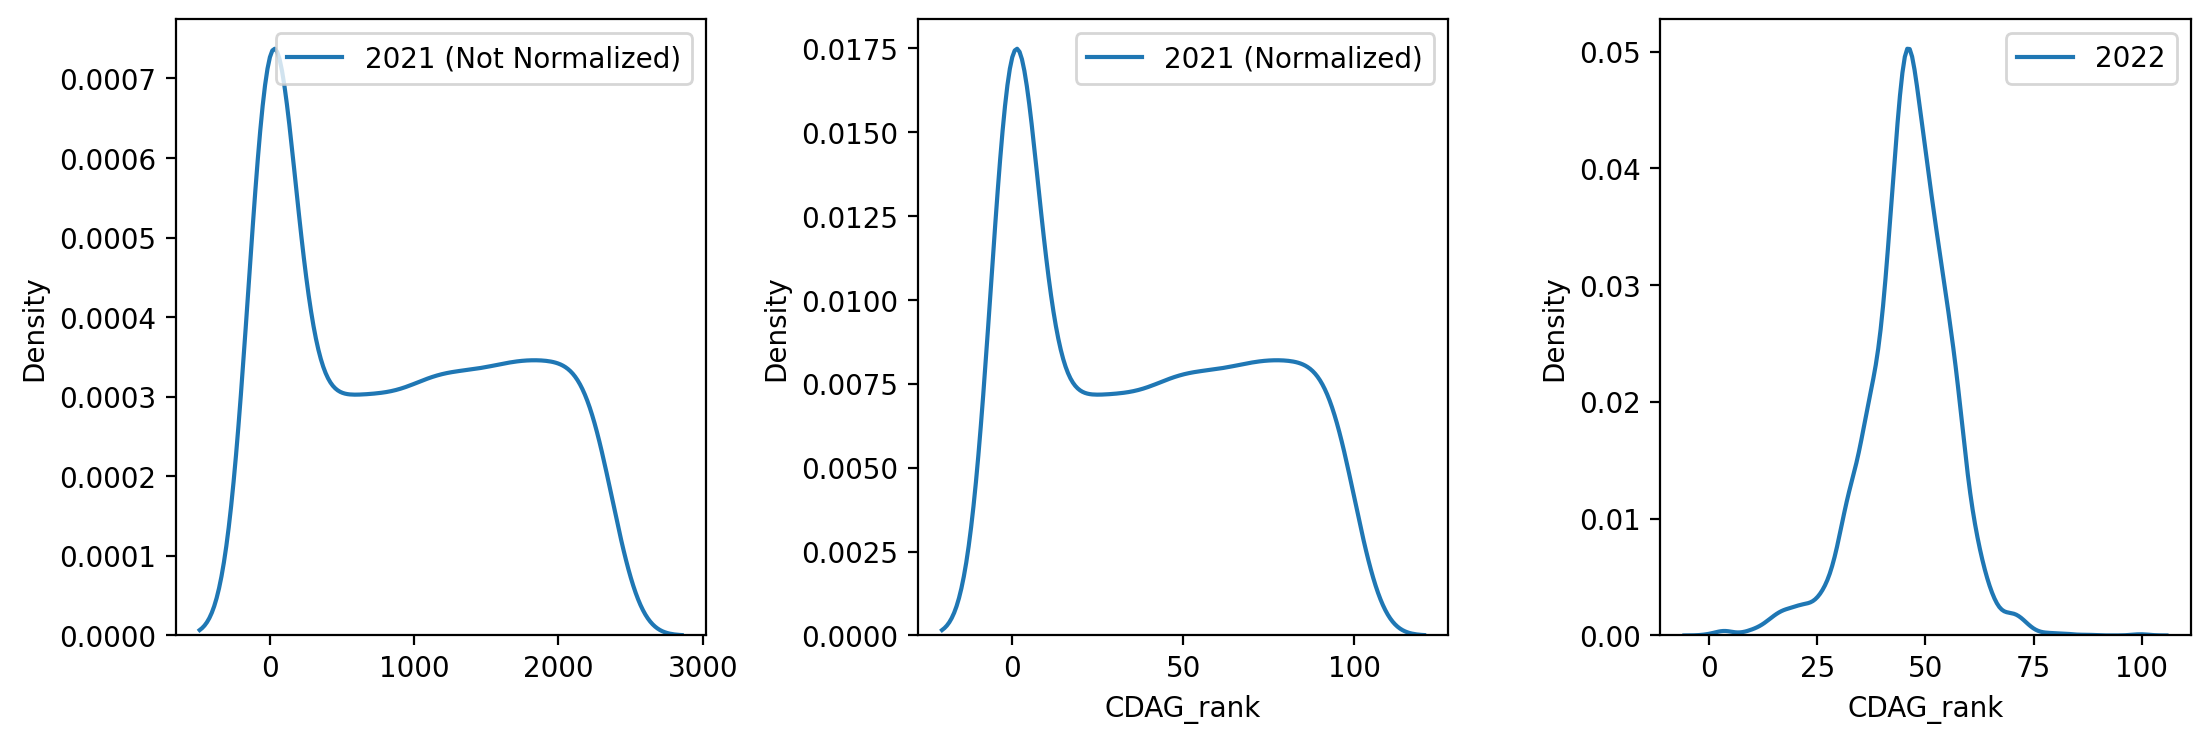

In [194]:
fig, ax = plt.subplots(1,3, figsize=(13,4))
out1 = sns.kdeplot(data=[df_2021['CDAG_rank']], ax=ax[0], legend=False)
out1.legend(labels=['2021 (Not Normalized)'])
out1 = sns.kdeplot(data=df_normalized, ax=ax[1], legend=False)
out1.legend(labels=['2021 (Normalized)'])
out2 = sns.kdeplot(data=df_CDAG['CDAG_rank'], ax=ax[2], legend=False)
out2.legend(labels=['2022'])
plt.subplots_adjust(wspace=0.4)
#fig.savefig('CDAG.png', dpi=300, transparent=True, bbox_inches='tight')

In [195]:
df_2021['CDAG_rank']=((df_2021['CDAG_rank']-df_2021['CDAG_rank'].min())/(df_2021['CDAG_rank'].max()-df_2021['CDAG_rank'].min())*100.)
df_2021['CDAG_rank'].describe()

count    2866.000000
mean       39.670060
std        33.339455
min         0.000000
25%         2.919477
50%        37.373524
75%        69.508853
max       100.000000
Name: CDAG_rank, dtype: float64

In [196]:
df_2022 = df_2022.merge(df_CDAG, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [197]:
df_2022.shape

(2866, 27)

#### N. Add SAFER Clearinghouse Data

This dataset will identify which CWS are wholesalers. Wholesalers sell water to multiple community water systems and all of them have a `DroughtExperienced` label of zero. This means predicting drought is a network problem -- those that are connected to wholesalers will likely not lose water, whereas those that are will are more at risk.

In [198]:
file_index = files.index('SAFER_CLEARINGHOUSE_Wholesalers.csv')
print("Reading in",files[file_index],".")
df_wholesalers = dfs[file_index]

Reading in SAFER_CLEARINGHOUSE_Wholesalers.csv .


In [199]:
df_wholesalers = df_wholesalers[['PWSID', 'PRIMARY_SERVICE_AREA_TYPE']].rename(columns={'PWSID':'CWSID'}).drop_duplicates().reset_index(drop=True)

In [200]:
df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].unique()

array(['RESIDENTIAL AREA              ', 'MOBILE HOME PARK              ',
       'K-12 SCHOOL                   ', 'MUNICIPALITY                  ',
       'WHOLESALER (SELLS WATER)      ', 'OTHER AREA                    ',
       'SCHOOL                        ', 'DAY CARE CENTER               ',
       'RECREATION AREA               ', 'INSTITUTION                   ',
       'HIGHER EDUCATION SCHOOL       ', 'MEDICAL FACILITY              ',
       'SECONDARY RESIDENCES          ', 'INDUSTRIAL/AGRICULTURAL       ',
       'OTHER RESIDENTIAL AREA        ', 'SUMMER CAMP                   ',
       'OTHER NON-TRANSIENT AREA      ', 'OTHER TRANSIENT AREA          ',
       'SUBDIVISION                   ', 'HOTEL/MOTEL                   ',
       'MOBILE HOME PARK,PRINC. RES.  ', 'RESTAURANT                    ',
       'SERVICE STATION               ', nan], dtype=object)

In [201]:
conditions = [df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].eq('WHOLESALER (SELLS WATER)      '),
              df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].ne('WHOLESALER (SELLS WATER)      ')]

choicelist = [1,0]

In [202]:
df_wholesalers['Wholesalers'] = np.select(conditions, choicelist, default=0)

In [203]:
df_wholesalers = df_wholesalers.drop(columns='PRIMARY_SERVICE_AREA_TYPE')

In [204]:
df_2022 = df_2022.merge(df_wholesalers, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [205]:
df_2022.shape

(2866, 28)

### Add 2022 Data

In [338]:
df_test_2022 = df_2022

In [339]:
df_test_2021 = df_2021

In [340]:
print(df_test_2022.shape)
column_list_2022 = list(df_test_2022.columns)

(2866, 28)


In [341]:
print(df_test_2021.shape)
column_list_2021 = list(df_test_2021.columns)

(2866, 53)


In [342]:
common_keys = list(set(column_list_2021) & set(column_list_2022))

In [343]:
common_keys

['BottledHauledWaterOrZeroSource',
 'Intertie',
 'Curtailment',
 'Score_1705',
 'ActiveGWSource',
 'WaterOutageDroughtViolation',
 'Score_1814',
 'Water Year',
 'Score_1704',
 'CurtailmentExemptionPetition',
 'CDAG_rank',
 'Score_1812',
 'Score_1706',
 'Score_1813',
 'DroughtExperienced',
 'Score_SCV',
 'Score_SCM',
 'ServiceConnections',
 'FundedProject',
 'Score_CriticallyOverdraftedGroundwaterBasin',
 'Score_1702',
 'ActiveSWSource',
 'CWSID',
 'SAFER_AccessibilityScore',
 'Score_1815']

In [344]:
df_test_2021_subset = df_test_2021[common_keys]

In [345]:
df_test_2022_subset = df_test_2022[common_keys]

In [346]:
df_test_2021_subset.shape

(2866, 25)

In [347]:
df_test_2022_subset.shape

(2866, 25)

In [354]:
df_combined = pd.concat([df_test_2021_subset, df_test_2022_subset]).reset_index(drop=True)

In [355]:
df_combined.shape

(5732, 25)

In [356]:
2866*2

5732

In [357]:
df_combined['Water Year'].unique()

array([2021, 2022])

### Exploratory Data Analysis

* Plot the Univarite Fisher Score
* Make a catplot of the curtailment versus population
* Make a catplot curtailment versus service connections
* Make a kernel density estimate pairplot for some risk scores 

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

selector=SelectKBest(f_classif, k='all')
collist = df.columns.tolist()
selector.fit(df[collist[1:]],df['DroughtExperienced'])
scores_fisher = selector.scores_
scores_fisher[np.isnan(scores_fisher)] = 0.0

features = df[collist[1:]].columns.to_list()
order = np.argsort(scores_fisher)
ordered_features_fisher = [features[i] for i in order]
ordered_normalized_scores_fisher = sorted(scores_fisher/np.nanmax(scores_fisher))
ordered_scores_fisher = sorted(scores_fisher)

ax.barh(ordered_features_fisher, ordered_normalized_scores_fisher)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
sns.set_theme(style='whitegrid')
fig = sns.catplot(data=df, x="Curtailment", y="Population", hue="DroughtExperienced")
#fig.savefig('curtailmentvpopulation.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
fig = sns.catplot(data=df, x="Curtailment", y="ServiceConnections", hue="DroughtExperienced")
#fig.savefig('curtailmentvserviceconnections.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
testdf = df[['DroughtExperienced', 'EAR2020DroughtRiskScore', 'CDAG_rank', 'SAFER_AccessibilityScore']]
testdf = testdf.rename(columns={'EAR2020DroughtRiskScore':'EAR Drought Risk Score', 'CDAG_rank': 'CDAG Risk Score', 'SAFER_AccessibilityScore': 'SAFER Accessibility Score'})
sns.pairplot(testdf, kind='kde', hue='DroughtExperienced', corner=True, plot_kws=dict(common_norm=False))#.savefig('kde.png', dpi=300, transparent=True, bbox_inches='tight')

Look at the features together with the each consituent outcome label.

Right now, the outcome label `DroughtExperienced` equals 1 if any of the following consituent outcomes equal 1:  `WaterOutageDroughtViolat|ion'`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, `FundedProject`. Otherwise, `DroughtExperienced` equals zero.

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.set_theme(style="white")

# Calculate Spearman correlation coefficient
corr = df_all.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot Spearman correlation coefficient as a diagonal heatmap
cmap = sns.color_palette('RdBu', as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.75, cbar_kws={"shrink": .5, "label": 'Spearman Correlation Coefficient'})
fig.savefig('spearman_with_labels_v2.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Split the data into a training and a validation set.

In [ ]:
y = df['DroughtExperienced']
X = df.drop(columns = 'DroughtExperienced')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7, shuffle=True)

print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")

### Scale the data

Scale the numeric features assuming the data obey a Gaussian distribution (is this is a reasonably fair assumption?). Leave the categorical features unscaled.

In [ ]:
numeric_features = [
    'ServiceConnections', 'Population', 'CDAG_rank',
    'SAFER_AccessibilityScore', 'ActiveGWSource', 'ActiveSWSource',
    'DSCI2WYAvg', 'TNCFlow2WYAvg', 
    'PWPhysicalAddressLat', 'PWPhysicalAddressLong', 
    'Flow Dry Season Max', 
    'Flow Dry Season Average', 'Flow Dry Season Standard Deviation', 'Flow Dry Wet Delta', 
    'DSCI 2021 Dry Season Max', 'DSCI 2021 Dry Season Average',
    'DSCI 2021 Dry Season Standard Deviation', 'DSCI 2021 Dry Wet Delta',
    'DSCI 2020 Dry Season Max', 'DSCI 2020 Dry Season Average',
    'DSCI 2020 Dry Season Standard Deviation', 'DSCI 2020 Dry Wet Delta',
    'DSCI 2019 Dry Season Max', 'DSCI 2019 Dry Season Average',
    'DSCI 2019 Dry Season Standard Deviation', 'DSCI 2019 Dry Wet Delta'#, 'gwe_avg', 'num_purchases_monthly', 'num_sales_monthly'
]

categorical_features = ['Score_SourceNumber', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 
       'Curtailment', 'Score_1702', 'Score_1705', 'Score_1706', 'Score_1812',
       'Score_1813', 'Score_1814', 'Score_1815', 'EAR2020DroughtRiskScore',
       'CurtailedWatershed', 'HUC4', 'FracturedRock', 'Intertie',
       'CentralValleyCounties', 'HUC_Categories',
                       ]

all_features = numeric_features + categorical_features

In [ ]:
if (len(numeric_features) + len(categorical_features)) == len(X.columns):
    print('All variables are included.')

Select and scale the numeric features.

In [ ]:
scaler = preprocessing.StandardScaler()

X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

Scale the validation set using the same mean and variance as the training set.

In [ ]:
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

Append the unscaled categorical features.

In [ ]:
X_train_categorical = np.array(X_train[categorical_features])
X_val_categorical = np.array(X_val[categorical_features])

X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

X_train_scaled.shape, X_val_scaled.shape

### Train the model

We use a Random Forest Classifier to train and test the model. Note that the class imbalance ratio here is roughly 1:20. 

To find the best estimator, we conduct an exhaustive search over two parameters: the number of estimators, or trees, and the class weight for the underrepresented positive class. We conduct this search using stratified 10-fold cross validation and optimize for the metric that calculates the area under the ROC curve.

Here is an example:
```
parameters = {'n_estimators': range(200,600,50), 'class_weight':[{0:1, 1: w} for w in [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]] }
```

In [ ]:
y_train.value_counts()

In [ ]:
def optimize_for_low_false_negative_rate(y_val, y_pred):
    fpr, fnr, thresholds = metrics.det_curve(y_val, y_pred, pos_label=1)
    return fnr[1]

In [ ]:
# Use GridSearchCV

# Identify custom scorer
low_fnr_scorer = metrics.make_scorer(optimize_for_low_false_negative_rate, greater_is_better=False)

# Define range for class weights
parameters = {'class_weight':[{0:1, 1: w} for w in [0.125, 0.25, 0.5, 1, 2, 4, 8]] }

# Initialize the random forest model
rf = RandomForestClassifier(max_features=len(all_features), n_estimators=300, n_jobs=-1, random_state=42)

# Do the grid search to find the best parameters
clf = GridSearchCV(rf, parameters, scoring=low_fnr_scorer, cv=5)

# Fit the model 
clf.fit(X_train_scaled, y_train)

# Predict the outcome with the best estimator
y_pred = clf.best_estimator_.predict(X_val_scaled)

In [ ]:
# Print the parameters of the best estimator
clf.best_estimator_

### Question 1: What are the most predictive features?

* In the original model, the most predictive features were static over time.
* After some feature engineering, our model shows that the most predictive features vary with time.
* We assess predictive capacity based on two metrics: the Univariate Fisher / ANOVA F Score or Gini Impurity Importance. Some features rank high on one measure, but low on the other. 

In [ ]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

features = all_features # Note that this is the correct order of feature names
scores_gini = clf.best_estimator_.feature_importances_

order = np.argsort(scores_gini)
ordered_features_gini = [features[i] for i in order]
ordered_normalized_scores_gini = sorted(scores_gini/np.nanmax(scores_gini))
ordered_scores_gini = sorted(scores_gini)

ax.barh(ordered_features_gini, ordered_normalized_scores_gini)
ax.set(xlabel = 'Normalized Gini Impurity')
fig.savefig('Gini.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
print(np.nanmax(ordered_scores_gini))
print(np.nanmax(ordered_scores_fisher))

In [ ]:
df_gini_scores = pd.DataFrame({'Scores': ordered_normalized_scores_gini, 'Features': ordered_features_gini, 'Type': ['Gini'] * len(ordered_features_gini)})
df_fisher_scores = pd.DataFrame({'Scores': ordered_normalized_scores_fisher, 'Features': ordered_features_fisher, 'Type': ['Fisher'] * len(ordered_features_fisher)})
df_scores = df_gini_scores.append(df_fisher_scores).reset_index().drop(columns=['index'])

In [ ]:
fig, ax = plt.subplots(figsize=(14,4))
sns.set_theme(style='whitegrid')

sns.barplot(orient="v", data=df_scores, x='Features', y='Scores', hue='Type')
ax.set(xlabel = 'Normalized Importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
ax.set_ylim([0,0.6])
fig.savefig('Gini_and_Fisher_pn.png', dpi=300, transparent=True, bbox_inches='tight')

Compare this to the features and scores in the previous model from the DDW ([see this Google sheet](https://docs.google.com/spreadsheets/d/17ZfqKys9XS0KR57rUTjGyJjk16dcf8GelyIgt_MYjVY/edit#gid=0)):

### Question 2: Does the model perform well?

In [ ]:
fig, ax = plt.subplots()
rfc_disp = metrics.RocCurveDisplay.from_estimator(clf.best_estimator_, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.show()
fig.savefig('ROC_AUC_fnr.png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
rfc_disp = metrics.DetCurveDisplay.from_estimator(clf.best_estimator_, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('Detection Error Tradeoff (DET) Curve')
plt.show()
fig.savefig('DET_fnr.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 3: What predictions does the model get wrong?

Some observations:
* False negatives serve small populations (less than 2000 people) with a seemingly high ratio of population to service connections. All but one was curtailed in the past.
* None of the false positives had a service connection moratorium in the past three years.

In [ ]:
y_val_out = y_val.reset_index()

In [ ]:
count = 0
count_false_positive = 0
count_false_negative = 0
count_true_positive = 0
count_true_negative = 0
examples = []
examples_false_positive = []
examples_false_negative = []
examples_true_positive = []
examples_true_negative = []
for i in range(len(y_pred)):
    if y_val_out.loc[i]['DroughtExperienced'] != y_pred[i]:
        #print(y_val_out.loc[i]['DroughtExperienced'], y_pred[i], y_val_out.loc[i]['index'])
        count += 1
        examples.append(y_val_out.loc[i]['index'])
    if (y_val_out.loc[i]['DroughtExperienced'] == 1.0) and (y_pred[i] == 0.0):
        count_false_negative += 1
        examples_false_negative.append(y_val_out.loc[i]['index'])        
    if (y_val_out.loc[i]['DroughtExperienced'] == 0.0) and (y_pred[i] == 1.0):
        count_false_positive += 1    
        examples_false_positive.append(y_val_out.loc[i]['index'])
    if (y_val_out.loc[i]['DroughtExperienced'] == 1.0) and (y_pred[i] == 1.0):
        count_true_positive += 1
        examples_true_positive.append(y_val_out.loc[i]['index'])        
    if (y_val_out.loc[i]['DroughtExperienced'] == 0.0) and (y_pred[i] == 0.0):
        count_true_negative += 1    
        examples_true_negative.append(y_val_out.loc[i]['index'])
print("Number of misclassifications:", count)
print("Number of false positives:", count_false_positive)
print("Number of false negatives:", count_false_negative)
print("Number of true positives:", count_true_positive)
print("Number of true negatives:", count_true_negative)
print("Number of correct classifications:", (len(y_pred) - count))
print("Number of total examples:", (len(y_pred)))

In [ ]:
df_false_positives = df.loc[examples_false_positive].reset_index(drop=True).assign(Classification='False Positive')
df_false_negatives = df.loc[examples_false_negative].reset_index(drop=True).assign(Classification='False Negative')
df_true_positives = df.loc[examples_true_positive].reset_index(drop=True).assign(Classification='True Positive')
df_true_negatives = df.loc[examples_true_negative].reset_index(drop=True).assign(Classification='True Negative')

In [ ]:
frames = [df_false_positives, df_false_negatives, df_true_positives, df_true_negatives]
df_all = pd.concat(frames)

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(19,12))
sns.kdeplot(df_all, x='SAFER_AccessibilityScore', hue='Classification', fill=True, ax=ax[0,0], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Curtailment', hue='Classification', fill=True, ax=ax[0,1], legend=False, common_norm=False)
sns.kdeplot(df_all, x='CDAG_rank', hue='Classification', fill=True, ax=ax[0,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='PWPhysicalAddressLong', hue='Classification', fill=True, ax=ax[0,3], legend=True, common_norm=False)
sns.kdeplot(df_all, x='Population', hue='Classification', fill=True, ax=ax[1,0], log_scale=True, legend=False, common_norm=False)
sns.kdeplot(df_all, x='ServiceConnections', hue='Classification', fill=True, ax=ax[1,1], log_scale=True, legend=False, common_norm=False)
sns.kdeplot(df_all, x='PWPhysicalAddressLat', hue='Classification', fill=True, ax=ax[1,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='DSCI 2021 Dry Season Standard Deviation', hue='Classification', fill=True, ax=ax[1,3], legend=False, common_norm=False)
sns.kdeplot(df_all, x='ActiveSWSource', hue='Classification', fill=True, ax=ax[2,0], legend=False, common_norm=False)
sns.kdeplot(df_all, x='ActiveGWSource', hue='Classification', fill=True, ax=ax[2,1], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Score_SCV', hue='Classification', fill=True, ax=ax[2,2], legend=False, common_norm=False)
sns.kdeplot(df_all, x='Score_SCM', hue='Classification', fill=True, ax=ax[2,3], legend=False, common_norm=False)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
fig.savefig('Misclassifications.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 4: Do more features improve model performance?

In [ ]:
print("The model has",len(features),"features.")
print("These are the features, in order of Gini Importance:", ordered_features_gini)

In [ ]:
auc_values = []
auc_std = []
for i in range(len(ordered_features_gini)):
    # Select the data
    y = df['DroughtExperienced']
    X = df[ordered_features_gini[i:]]
    total_features = X.columns.to_list()
    
    auc_scores = []
    for j in range(3):    # This should eventually be 100
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)

        # Identify the numeric and categorical features
        total_numeric_features = list(set(total_features).intersection(numeric_features))
        total_categorical_features = list(set(total_features).intersection(categorical_features))

        # Select and scale the numeric features
        if total_numeric_features:
            scaler = preprocessing.StandardScaler()
            X_train_numeric = X_train[total_numeric_features]
            X_val_numeric = X_val[total_numeric_features]
            X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
            X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

        # Select the categorical features
        if total_categorical_features:
            X_train_categorical = np.array(X_train[total_categorical_features])
            X_val_categorical = np.array(X_val[total_categorical_features])

        # Create training and validation sets
        if total_numeric_features and total_categorical_features:
            X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
            X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
        if total_numeric_features and not total_categorical_features:
            X_train_scaled = X_train_numeric_scaled
            X_val_scaled = X_val_numeric_scaled
        if not total_numeric_features and total_categorical_features:
            X_train_scaled = X_train_categorical
            X_val_scaled = X_val_categorical

        # Train the model
        clf = RandomForestClassifier(max_features=46, n_estimators=770, n_jobs=-1, random_state=42)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_val_scaled)

        # Calculate the AUC
        rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba');
        auc_scores.append(rfc_disp.roc_auc)
        
    auc_std.append(np.std(auc_scores))
    auc_values.append(np.mean(auc_scores))
    print(i,np.mean(auc_scores), np.std(auc_scores))

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(45),np.flip(auc_values), yerr=np.flip(auc_std), marker=".", markersize=10)
ax.set_xlabel('Features')
ax.set_ylabel('Performance (AUC)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.66, 0.98])
fig.savefig('performancevsfeatures.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 6: Do different labels improve model performance?

In [ ]:
print("Number of positive examples in DroughtExperienced:",len(df_all[df_all['DroughtExperienced'] == 1]))
print("Number of positive examples in WaterOutageDroughtViolation:",len(df_all[df_all['WaterOutageDroughtViolation'] == 1]))
print("Number of positive examples in BottledHauledWaterOrZeroSource:",len(df_all[df_all['BottledHauledWaterOrZeroSource'] == 1]))
print("Number of positive examples in CurtailmentExemptionPetition:",len(df_all[df_all['CurtailmentExemptionPetition'] == 1]))
print("Number of positive examples in Score_1704:",len(df_all[df_all['Score_1704'] == 1]))
print("Number of positive examples in FundedProject:",len(df_all[df_all['FundedProject'] == 1]))

In [ ]:
outcome_label = [
 'DroughtExperienced',
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'Score_1704',
 'FundedProject']

In [ ]:
auc_values_per_label = []
auc_std_per_label = []

for k in range(len(outcome_label)):
    # Select the outcome label
    y = df_all[outcome_label[k]]
    print(outcome_label[k])

    auc_values = []
    auc_std = []
    for i in range(len(ordered_features_gini)):
        # Select the features
        X = df_all[ordered_features_gini[i:]]
        total_features = X.columns.to_list()

        auc_scores = []
        for j in range(5):    # This should eventually be 100
            # Split the data
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=7)

            # Identify the numeric and categorical features
            total_numeric_features = list(set(total_features).intersection(numeric_features))
            total_categorical_features = list(set(total_features).intersection(categorical_features))

            # Select and scale the numeric features
            if total_numeric_features:
                scaler = preprocessing.StandardScaler()
                X_train_numeric = X_train[total_numeric_features]
                X_val_numeric = X_val[total_numeric_features]
                X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
                X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

            # Select the categorical features
            if total_categorical_features:
                X_train_categorical = np.array(X_train[total_categorical_features])
                X_val_categorical = np.array(X_val[total_categorical_features])

            # Create training and validation sets
            if total_numeric_features and total_categorical_features:
                X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
                X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
            if total_numeric_features and not total_categorical_features:
                X_train_scaled = X_train_numeric_scaled
                X_val_scaled = X_val_numeric_scaled
            if not total_numeric_features and total_categorical_features:
                X_train_scaled = X_train_categorical
                X_val_scaled = X_val_categorical

            # Train the model
            clf = RandomForestClassifier(max_features=46, n_estimators=770, n_jobs=-1, random_state=42)
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_val_scaled)

            # Calculate the AUC
            rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba');
            auc_scores.append(rfc_disp.roc_auc)
        
        auc_std.append(np.std(auc_scores))
        auc_values.append(np.mean(auc_scores))
        print(i,np.mean(auc_scores), np.std(auc_scores))

    auc_std_per_label.append(auc_std)
    auc_values_per_label.append(auc_values)

In [ ]:
df_auc = pd.DataFrame({'AUC Scores': auc_values_per_label, 'AUC Standard Deviation': auc_std_per_label, 'Outcome Label': outcome_label})

In [ ]:
df_auc

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(len(df_auc['AUC Scores'][0])),np.flip(df_auc['AUC Scores'][0]), yerr=np.flip(df_auc['AUC Standard Deviation'][0]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][0])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][2])),np.flip(df_auc['AUC Scores'][2]), yerr=np.flip(df_auc['AUC Standard Deviation'][2]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][2])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][3])),np.flip(df_auc['AUC Scores'][3]), yerr=np.flip(df_auc['AUC Standard Deviation'][3]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][3])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][5])),np.flip(df_auc['AUC Scores'][5]), yerr=np.flip(df_auc['AUC Standard Deviation'][5]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][5])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][4])),np.flip(df_auc['AUC Scores'][4]), yerr=np.flip(df_auc['AUC Standard Deviation'][4]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][4])
ax.errorbar(np.arange(len(df_auc['AUC Scores'][1])),np.flip(df_auc['AUC Scores'][1]), yerr=np.flip(df_auc['AUC Standard Deviation'][1]), 
            marker=".", markersize=10, label=df_auc['Outcome Label'][1])
ax.set_xlabel('Features')
ax.set_ylabel('Performance (AUC)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.42, 1.03])
ax.legend()
fig.savefig('performancevsfeaturesvslabel_nogw.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 7: Where are these drought-impacted CWS?

In [ ]:
drought_df = df[df['DroughtExperienced'] == 1]
safe_df = df[df['DroughtExperienced'] == 0]

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-125, -114, 31, 43], crs=ccrs.PlateCarree())

odi_blue = "#0D4F8C"
odi_red = "#C24629"

ax.plot(safe_df['PWPhysicalAddressLong'],safe_df['PWPhysicalAddressLat'], marker='o', 
        linestyle='None', color=odi_blue, markersize=4, alpha=0.3, transform=ccrs.PlateCarree())
ax.plot(drought_df['PWPhysicalAddressLong'],drought_df['PWPhysicalAddressLat'], marker='o', 
        linestyle='None', color=odi_red, markersize=4, alpha=0.8, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)

plt.show()

#fig.savefig('locations.png', dpi=300, transparent=True, bbox_inches='tight')